# HW 1 Vanilla NN
## Jacob Child
## Jan 13, 2025

Download the [Auto MPG dataset](https://archive.ics.uci.edu/dataset/9/auto+mpg), specifically the file auto-mpg.data. The auto-mpg.names file describes each of the 9 columns. Our goal will be to use this data to predict an automobile’s mpg as a function of the other parameters (except for “car name”, which we won’t need).

In [1]:
# Needed Packages 
import os
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

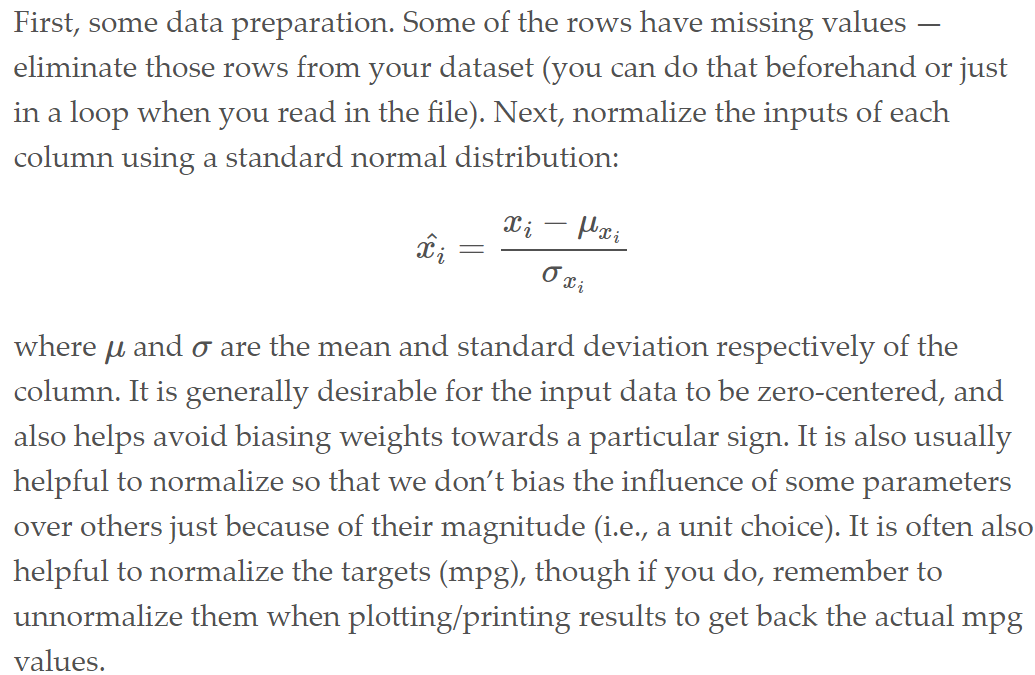

In [34]:
# Load data- I can just fetch it from the repo, but as I don't want to import it every time I'll download it under DataSets and import it from there
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
df = pd.read_csv('../DataSets/HW1Data/auto-mpg.data', names = column_names, sep = '\s+', na_values ='?').dropna() # loads the data, names the columns, and drops rows with na
df_org = pd.read_csv('../DataSets/HW1Data/auto-mpg.data', names = column_names, sep = '\s+', na_values ='?').dropna() # loads the data, names the columns, and drops rows with na

# normalize each column with xnew = (x - mean(x)) / std(x)
for column in column_names[0:8]: #to exclude car_name
    df[column] = (df[column] - df[column].mean()) / df[column].std()

# get rid of car_name
df = df.drop('car_name', axis=1)
# The below can actually all be done with the torch dataset things, so I will do that in the next cell
# Split data 80/20 train/test
# df_train = df.sample(frac=0.8, random_state=200) # splits 80% to test random_state is the seed for the random number generator
# df_test = df.drop(df_train.index)
# print(df.head()) #prints the first 5 rows of the data

df.shape


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\child\AppData\Local\Temp\ipykernel_31232\4087005235.py:3: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('../DataSets/HW1Data/auto-mpg.data', names = column_names, sep = '\s+', na_values ='?').dropna() # loads the data, names the columns, and drops rows with na
C:\Users\child\AppData\Local\Temp\ipykernel_31232\4087005235.py:4: SyntaxWarning: invalid escape sequence '\s'
  df_org = pd.read_csv('../DataSets/HW1Data/auto-mpg.data', names = column_names, sep = '\s+', na_values ='?').dropna() # loads the data, names the columns, and drops rows with na


(392, 8)

"Our goal will be to use this data to predict an automobile’s mpg as a function of the other parameters (except for “car name”, which we won’t need)." 
"Setup a neural net with at least two layers (at leasst one hidden layer). You’ll need to experiment some with different layer widths, activation functions, batch sizes, learning rates, and number of epochs. You should be able to an average absolute error of under 2 mpg on the test set. You’ll see some scatter in the results for sure, but that’s still pretty decent predictive capability given how little data we have (and no physics)."

In [3]:
# Setup data to be used in PyTorch
# Separate features and target and convert to tensors
features = torch.tensor(df.drop(columns=['mpg']).values, dtype = torch.float32) # rows are the samples, columns are the features, so the length of the row is the number of nodes in the input layer
targets = torch.tensor(df['mpg'].values.reshape(-1, 1), dtype = torch.float32) # convert to a tensor and reshape to a column vector

# Create a dataset class
dataset = TensorDataset(features, targets)
# Split the data into training and testing sets
train_ds, test_ds = random_split(dataset, [0.8, 0.2])

# Create data loaders
batch_size = 32
train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size = batch_size, shuffle=True)

In [24]:
train_ds[0][0].dtype

torch.float32

In [49]:
# Define my network class 
class VanillaNN(nn.Module):
    
    def __init__(self, ninf, noutf):
        super().__init__() # super is a reference to the parent class, in this case nn.Module, so it is being initialized
        
        self.network = nn.Sequential(
            # These are hyper parameters, number of layers and number of nodes in each layer
            nn.Linear(ninf, 32), # nn.Linear(input, output), this is the connection from the input layer to the first hidden layer
            nn.ReLU(),
            nn.Linear(32, 32), # hidden layer 1 to hidden layer 2 org = nn.Linear(32, 32)
            nn.ReLU(),
            nn.Linear(32, noutf) #! make sure to end on linear layer, this is the connection from the last hidden layer to the output layer
        )
        
    def forward(self, x):
        # print(type(x))
        return self.network(x)

In [30]:
# Define my training function 
def train(dataloader, modelf, loss_fnf, optimizerf):
    # running this all once is one epoch
    
    modelf.train()
    num_batches = len(dataloader)
    train_loss = 0
    
    for X, y in dataloader:
        # X, y = X.to(device), y.to(device)
        # print(type(X), "train func")
        # Compute prediction error
        pred = modelf(X)
        loss = loss_fnf(pred, y)

        # Backpropagation
        loss.backward() #computes derivatives
        optimizerf.step() #updates the weights or steps in a direction
        optimizerf.zero_grad() # it is doing things in place to save memory, so zeroed to start ready for next time
        train_loss += loss.item()
    
    train_loss /= num_batches
    
    print(f"Train loss: {train_loss:>8f} \n") # prints every epoch
    return train_loss

In [31]:
# Define my testing function
def test(dataloader, model, loss_fn):

    model.eval()
    
    num_batches = len(dataloader)
    test_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            # print(type(X))
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # item() gets the value of the tensor
    
    test_loss /= num_batches # average loss per batch, the /= is the same as test_loss = test_loss / num_batches
    print(f"Test loss: {test_loss:>8f} \n") # prints every epoch
    return test_loss

Train loss: 0.790668 

Test loss: 1.198341 

Train loss: 0.675438 

Test loss: 0.892208 

Train loss: 0.594529 

Test loss: 0.858632 

Train loss: 0.538300 

Test loss: 0.830529 

Train loss: 0.477296 

Test loss: 0.716289 

Train loss: 0.412942 

Test loss: 0.543315 

Train loss: 0.343506 

Test loss: 0.483839 

Train loss: 0.281147 

Test loss: 0.355767 

Train loss: 0.243172 

Test loss: 0.269482 

Train loss: 0.214166 

Test loss: 0.237698 

Train loss: 0.191470 

Test loss: 0.259126 

Train loss: 0.175567 

Test loss: 0.191594 

Train loss: 0.164932 

Test loss: 0.178541 

Train loss: 0.154841 

Test loss: 0.202304 

Train loss: 0.147503 

Test loss: 0.166813 

Train loss: 0.142374 

Test loss: 0.156013 

Train loss: 0.136014 

Test loss: 0.164161 

Train loss: 0.131949 

Test loss: 0.160120 

Train loss: 0.127722 

Test loss: 0.146412 

Train loss: 0.124336 

Test loss: 0.141490 

Train loss: 0.121941 

Test loss: 0.154391 

Train loss: 0.117604 

Test loss: 0.155872 

Train loss

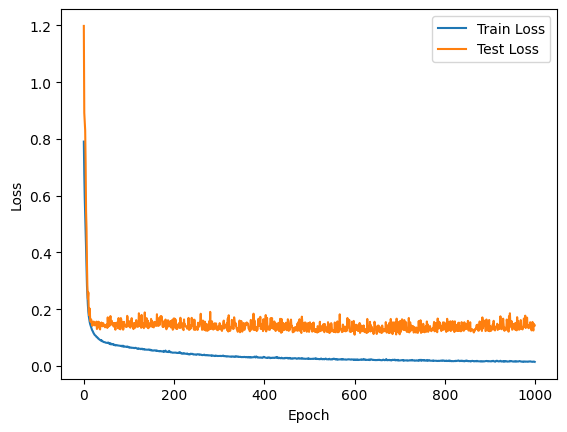

In [50]:
# Model setup 
nin = features.shape[1] # number of nodes in the input layer
nout = 1 # number of nodes in the output layer
model = VanillaNN(nin, nout)
loss_fn = nn.MSELoss() # Mean Squared Error loss function
optimizer = optim.Adam(model.parameters(), lr = 1e-3) # Adam optimizer, lr is learning rate, org = 1e-3

epochs = 1000 # number of epochs org = 1000
train_losses = []
test_losses = []
for e in range(epochs): 
    # print(f"Epoch {e+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
# plot so I can evaluate 
plt.figure() 
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


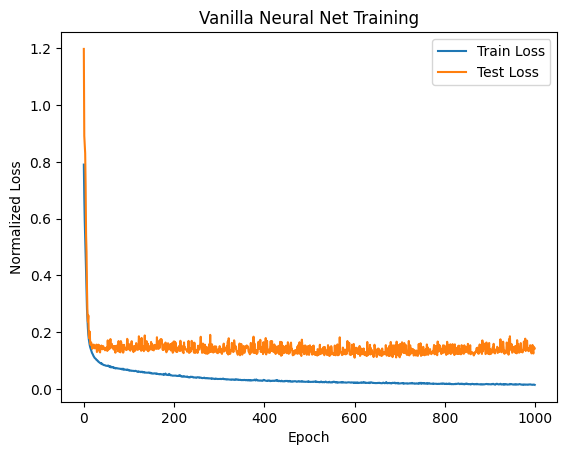

In [53]:
# plot so I can evaluate 
plt.figure() 
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.title('Vanilla Neural Net Training')
plt.legend()
plt.show()

In [52]:
# training is complete, run on the test set 
final_loss = test(test_dataloader, model, loss_fn)
print(f"Final Test Loss: {final_loss:>8f} \n") 
# unnormalize the final_loss
mean_org = df_org['mpg'].mean()
std_org = df_org['mpg'].std()
FinalFinal_Loss = final_loss * std_org
print(f"Final Test Loss in mpg: {FinalFinal_Loss:>8f} \n")


Test loss: 0.141324 

Final Test Loss: 0.141324 

Final Test Loss in mpg: 1.103031 



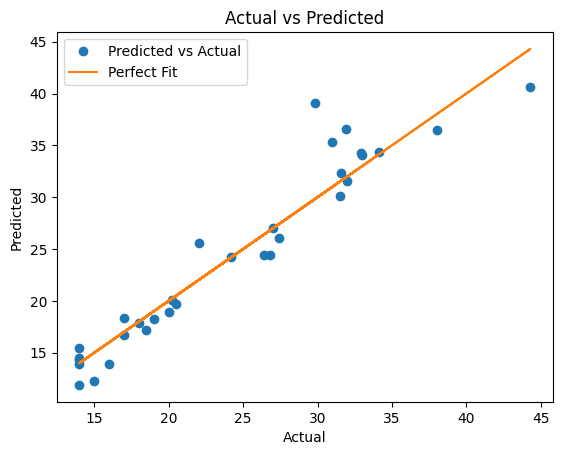

In [ ]:
# For fun, run the model on the test set and plot it against the actual values
model.eval()
with torch.no_grad():
    X, y = next(iter(test_dataloader))
    pred = model(X)
    # unnormalize the values
    y = y * std_org + mean_org
    pred = pred * std_org + mean_org
    plt.figure()
    plt.plot(y.numpy(), pred.numpy(), 'o', label='Predicted vs Actual')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    # plot a line of perfect fit, ie. y = x
    plt.plot(y.numpy(), y.numpy(), label='Perfect Fit')
    plt.legend()
    plt.title('Actual vs Predicted')
    plt.show()

